<a href="https://colab.research.google.com/github/rajlm10/D2L-Torch/blob/main/D2L_GANs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install d2l -q

     |████████████████████████████████| 82 kB 447 kB/s 
     |████████████████████████████████| 61 kB 7.5 MB/s 
     |████████████████████████████████| 9.9 MB 13.9 MB/s 
     |████████████████████████████████| 11.2 MB 28.2 MB/s 
     |████████████████████████████████| 15.7 MB 22.2 MB/s 
     |████████████████████████████████| 930 kB 48.1 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.25.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [ ]:
import torch
from torch import nn
from d2l import torch as d2l

# GAN for sampling a Gaussian

In [ ]:
X = torch.normal(0.0, 1, (1000, 2))
A = torch.tensor([[1, 2], [-0.1, 0.5]]) 
b = torch.tensor([1, 2])
data = torch.matmul(X, A) + b

The covariance matrix is
tensor([[1.0100, 1.9500],
        [1.9500, 4.2500]])


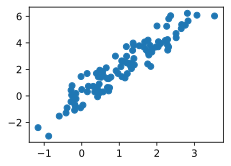

In [ ]:
d2l.set_figsize()
d2l.plt.scatter(data[:100, (0)].detach().numpy(), data[:100, (1)].detach().numpy()); 
print(f'The covariance matrix is\n{torch.matmul(A.T, A)}')

In [ ]:
def create_iterator(dataset,batch_size,is_train=True):
  dataset=torch.utils.data.TensorDataset(*dataset)

  return torch.utils.data.DataLoader(dataset,batch_size,shuffle=is_train)

In [ ]:
batch_size = 8
data_iter= create_iterator((data,), batch_size)

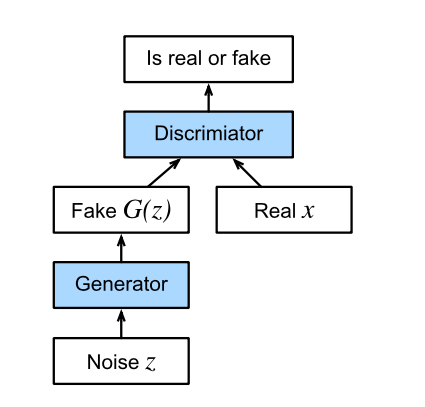

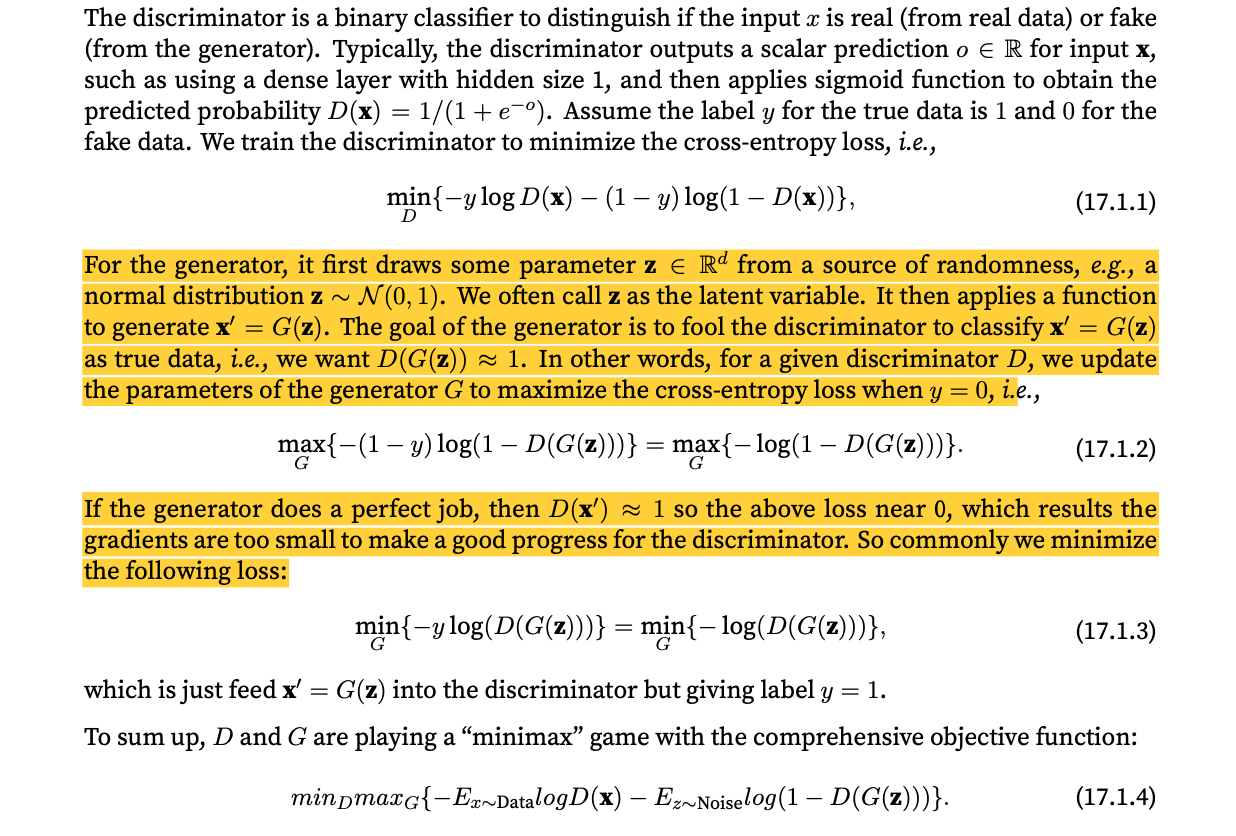

In [ ]:
def get_noise(batch_size, z_dim, device):
  return torch.randn(batch_size, z_dim, device=device)

In [ ]:
class Generator(nn.Module):
  def __init__(self, z_dim=2, out_dim=2):
    super(Generator, self).__init__()
    self.gen = nn.Sequential(nn.Linear(z_dim,out_dim))
  
  def forward(self, noise):
    #noise: a noise tensor with dimensions (batch_size, z_dim)
    return self.gen(noise)

In [ ]:
class Discriminator(nn.Module):
  def __init__(self, in_dim=2, hidden_dim_1=5,hidden_dim_2=3,out_dim=1):
    super(Discriminator, self).__init__()
    self.disc = nn.Sequential(
        nn.Linear(in_dim,hidden_dim_1),
        nn.Tanh(),
        nn.Linear(hidden_dim_1,hidden_dim_2),
        nn.Tanh(),
        nn.Linear(hidden_dim_2,out_dim),
        )
  
  def forward(self, X):
    #X: a tensor with dimensions (batch_size, in_dim)
    return self.disc(X)

In [ ]:
def get_disc_loss_and_fakes(gen, disc, criterion, X, batch_size, z_dim, device):
  fake_noise = get_noise(batch_size, z_dim, device=device)
  fakes = gen(fake_noise)
  disc_fake_pred = disc(fakes.detach()) #Important to detach
  disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))
  disc_real_pred = disc(X)
  disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))
  disc_loss = (disc_fake_loss + disc_real_loss) / 2
  return disc_loss, fakes

In [ ]:
def get_gen_loss(fakes, disc, criterion):
  disc_fake_pred = disc(fakes)
  gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))
  return gen_loss

In [ ]:
def train(gen,disc,data_iter,num_epochs, lr_D, lr_G, z_dim, device, data):
  criterion = nn.BCEWithLogitsLoss(reduction='sum')
  for w in disc.parameters():
    nn.init.normal_(w, 0, 0.02) 
  for w in gen.parameters():
    nn.init.normal_(w, 0, 0.02)
  
  trainer_D = torch.optim.Adam(disc.parameters(), lr=lr_D) 
  trainer_G = torch.optim.Adam(gen.parameters(), lr=lr_G)

  #Plotting Utils
  animator = d2l.Animator(xlabel='epoch', ylabel='loss',xlim=[1, num_epochs], 
                          nrows=2, figsize=(5, 5),legend=['discriminator', 'generator'])
  animator.fig.subplots_adjust(hspace=0.3)

  for epoch in range(num_epochs):
    # Train one epoch
    timer = d2l.Timer()
    metric = d2l.Accumulator(3) # loss_D, loss_G, num_examples

    for (X,) in data_iter:
      X = X.to(device)
      trainer_D.zero_grad()
      disc_loss, fakes = get_disc_loss_and_fakes(gen, disc, criterion, X, X.shape[0], z_dim, device)
      disc_loss.backward()
      trainer_D.step()

      trainer_G.zero_grad()
      gen_loss = get_gen_loss(fakes, disc, criterion)
      gen_loss.backward()
      trainer_G.step()

      metric.add(disc_loss,gen_loss,X.shape[0])
    
    disc_loss, gen_loss = metric[0]/metric[2], metric[1]/metric[2]  
    animator.add(epoch + 1, (disc_loss, gen_loss))
    print(f'Epoch {epoch}: loss_D {disc_loss:.3f}, loss_G {gen_loss:.3f}')
      
  #Plot generated vs Real
  Z = torch.normal(0, 1, size=(100, z_dim)).to(device) 
  fake_X = gen(Z).cpu().detach().numpy() 
  animator.axes[1].cla() 
  animator.axes[1].scatter(data[:, 0], data[:, 1]) 
  animator.axes[1].scatter(fake_X[:, 0], fake_X[:, 1]) 
  animator.axes[1].legend(['real', 'generated'])
  #End of plotting code
  print(f'{metric[2] / timer.stop():.1f} examples/sec on device {device}')


In [ ]:
device= d2l.try_gpu()
gen = Generator(z_dim=2,out_dim=2).to(device)
disc= Discriminator(in_dim=2, hidden_dim_1=5,hidden_dim_2=3,out_dim=1).to(device)
lr_D, lr_G, z_dim, num_epochs = 0.05, 0.005 , 2, 20


Epoch 19: loss_D 0.693, loss_G 0.692
1551.7 examples/sec on device cuda:0


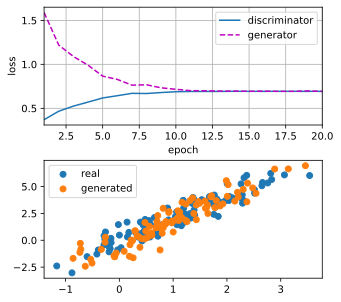

In [ ]:
train(gen, disc, data_iter, num_epochs, lr_D, lr_G, z_dim, device, data[:100].detach().numpy())

# DCGAN

In [ ]:
import torchvision
import warnings
import multiprocessing

In [ ]:
d2l.DATA_HUB['pokemon'] = (d2l.DATA_URL + 'pokemon.zip', 'c065c0e2593b8b161a2d7873e42418bf6a21106c')
data_dir = d2l.download_extract('pokemon')
pokemon = torchvision.datasets.ImageFolder(data_dir)

In [ ]:
batch_size = 256
transformer = torchvision.transforms.Compose([torchvision.transforms.Resize((64, 64)), 
                                              torchvision.transforms.ToTensor(), 
                                              torchvision.transforms.Normalize(0.5, 0.5)])

#Alternatively pass transformer to ImageFolder
pokemon.transform = transformer

data_iter = torch.utils.data.DataLoader(pokemon, batch_size=batch_size,shuffle=True, num_workers=multiprocessing.cpu_count())

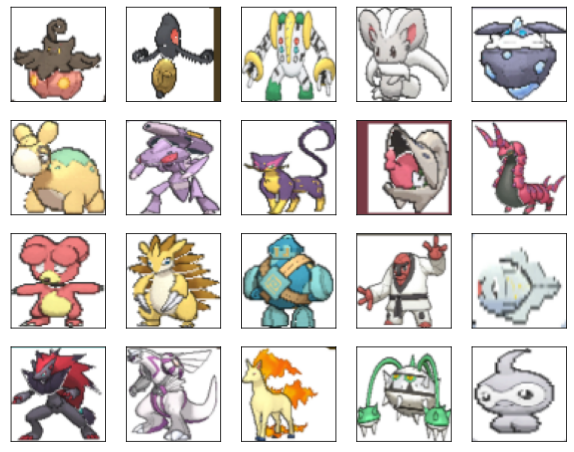

In [ ]:
warnings.filterwarnings('ignore') 
d2l.set_figsize((4, 4))
for X, y in data_iter:
  imgs = X[0:20,:,:,:].permute(0, 2, 3, 1)/2+0.5 
  d2l.show_images(imgs, num_rows=4, num_cols=5,scale=2) 
  break

For a transposed convolution, here is how the height and width are affected

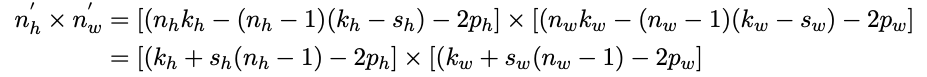

In [ ]:
class Generator_Block(nn.Module):
  def __init__(self, out_channels, in_channels=3, kernel_size=4, strides=2, padding=1, **kwargs):
    super(Generator_Block, self).__init__(**kwargs)
    self.conv2d_trans = nn.ConvTranspose2d(in_channels, out_channels,kernel_size, strides, padding, bias=False)
    self.batch_norm = nn.BatchNorm2d(out_channels)
    self.activation = nn.ReLU(inplace=True)
  
  def forward(self, X):
    return self.activation(self.batch_norm(self.conv2d_trans(X)))

In [ ]:
class Generator(nn.Module):
  def __init__(self, z_dim=100, hidden_channels=64):
    super(Generator, self).__init__()
    self.gen = nn.Sequential(
        # b,z_dim,1,1 -> b,64*8,4,4 (use formula above)
        Generator_Block(in_channels=100, out_channels=hidden_channels*8,strides=1, padding=0),
        # b,64*8,4,4 -> b,64*4,8,8
        Generator_Block(in_channels=hidden_channels*8, out_channels=hidden_channels*4),
        #b,64*4,8,8, -> b,64*2,16,16
        Generator_Block(in_channels=hidden_channels*4, out_channels=hidden_channels*2),
        #b,64*2,16,16, -> b,64,32,32
        Generator_Block(in_channels=hidden_channels*2, out_channels=hidden_channels),
        #Do not apply batch norm to last layer
        #b,64,32,32 -> b,3,64,64
        nn.ConvTranspose2d(in_channels=hidden_channels, out_channels=3,kernel_size=4, stride=2, padding=1, bias=False),
        nn.Tanh()
      )
  
  def forward(self, noise):
    #noise: a noise tensor with dimensions (batch_size, z_dim)
    return self.gen(noise[:,:,None,None]) #(batch_size, z_dim,1,1)

After convolution, here is how the height and width are affected

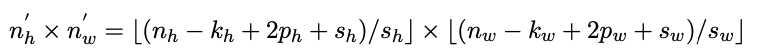

In [ ]:
class Discriminator_Block(nn.Module):
  def __init__(self, out_channels, in_channels=3, kernel_size=4, strides=2,padding=1, alpha=0.2, **kwargs):
    super(Discriminator_Block, self).__init__(**kwargs)
    self.conv2d = nn.Conv2d(in_channels, out_channels, kernel_size,strides, padding, bias=False)
    self.batch_norm = nn.BatchNorm2d(out_channels)
    self.activation = nn.LeakyReLU(alpha, inplace=True)
  
  def forward(self, X):
    return self.activation(self.batch_norm(self.conv2d(X)))

In [ ]:
class Discriminator(nn.Module):
  def __init__(self, in_dim=3, hidden_channels=64):
    super(Discriminator, self).__init__()
    self.disc = nn.Sequential(
        # b,3,64,64 -> b,64,32,32 (use formula above)
        Discriminator_Block(in_channels=3, out_channels=hidden_channels),
        # b,64,32,32 -> b,64*2,16,16
        Discriminator_Block(in_channels=hidden_channels, out_channels=hidden_channels*2),
        #b,64*2,16,16, -> b,64*4,8,8
        Discriminator_Block(in_channels=hidden_channels*2, out_channels=hidden_channels*4),
        #b,64*4,8,8 -> b,64*8,4,4
        Discriminator_Block(in_channels=hidden_channels*4, out_channels=hidden_channels*8),
        #Do not apply batch norm and activation to last layer
        #b,64*8,4,4 -> b,1,1,1 since padding is 0 and stride is 1 (by default in nn.Conv2d)
        nn.Conv2d(in_channels=hidden_channels*8, out_channels=1, kernel_size=4, bias=False),
      )
  
  def forward(self, X):
    #noise: an image with dimensions (batch_size, 3, 64 ,64)
    return self.disc(X) #(batch_size, 1,1,1)

**We change β1 in Adam from 0.9 to 0.5. It decreases the smoothness of the momentum, the exponentially weighted moving average of past gradients, to take care of the rapid changing gradients because the generator and the discriminator fight with each other.**

In [ ]:
def train(gen,disc,data_iter,num_epochs, lr, z_dim, device):
  criterion = nn.BCEWithLogitsLoss(reduction='sum')
  for w in disc.parameters():
    nn.init.normal_(w, 0, 0.02) 
  for w in gen.parameters():
    nn.init.normal_(w, 0, 0.02)
  gen, disc =gen.to(device), disc.to(device)

  #We lower the momentum B
  trainer_hp = {'lr': lr, 'betas': [0.5,0.999]}
  trainer_D = torch.optim.Adam(disc.parameters(), **trainer_hp) 
  trainer_G = torch.optim.Adam(gen.parameters(), **trainer_hp)

  #Plotting Utils
  animator = d2l.Animator(xlabel='epoch', ylabel='loss',xlim=[1, num_epochs], 
                          nrows=2, figsize=(5, 5),legend=['discriminator', 'generator'])
  animator.fig.subplots_adjust(hspace=0.3)

  for epoch in range(1, num_epochs + 1):
    # Train one epoch
    timer = d2l.Timer()
    metric = d2l.Accumulator(3) # loss_D, loss_G, num_examples

    for X, _ in data_iter:
      X = X.to(device)
      trainer_D.zero_grad()
      disc_loss, fakes = get_disc_loss_and_fakes(gen, disc, criterion, X, X.shape[0], z_dim, device)
      disc_loss.backward()
      trainer_D.step()

      trainer_G.zero_grad()
      gen_loss = get_gen_loss(fakes, disc, criterion)
      gen_loss.backward()
      trainer_G.step()

      metric.add(disc_loss,gen_loss,X.shape[0])

    disc_loss, gen_loss = metric[0]/metric[2], metric[1]/metric[2]  
    animator.add(epoch, (disc_loss, gen_loss))
    print(f'Epoch {epoch}: loss_D {disc_loss:.3f}, loss_G {gen_loss:.3f}')

  #Plot generated vs Real
  Z = torch.normal(0, 1, size=(21, z_dim)).to(device) 
  fake_X = gen(Z).permute(0, 2, 3, 1) / 2 + 0.5
  imgs = torch.cat([torch.cat([fake_X[i * 7 + j].cpu().detach() for j in range(7)], dim=1) 
                    for i in range(len(fake_X)//7)], dim=0) 
  
  animator.axes[1].cla() 
  animator.axes[1].imshow(imgs)
  #End of plotting code
  print(f'{metric[2] / timer.stop():.1f} examples/sec on device {device}')








In [ ]:
device= d2l.try_gpu()
gen = Generator(z_dim=100, hidden_channels=64)
disc= Discriminator(in_dim=3, hidden_channels=64)
lr, z_dim, num_epochs =  0.002 , 100 , 43


Epoch 43: loss_D 0.113, loss_G 6.551
1576.6 examples/sec on device cuda:0


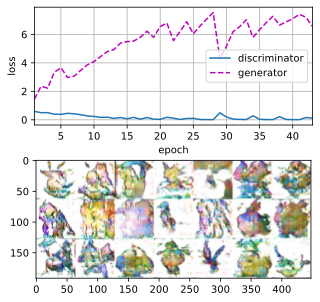

In [ ]:
train(gen, disc, data_iter, num_epochs, lr, z_dim, device)